## Global vars/imports

In [43]:
base_dir='/tmp/visual'
model_dir=base_dir + '/model'
dataset_dir='https://workshopml.spock.cloud/datasets/furniture'

In [2]:
# kernel conda_mxnet_p36

%matplotlib inline
import json
import logging
import os
import time
import numpy as np
import mxnet as mx
import sagemaker
import cv2
import pandas as pd
import tarfile
import inspect
import random
import boto3
import matplotlib.pyplot as plt

from sagemaker.mxnet import MXNet

from PIL import Image
from sagemaker.predictor import json_serializer, json_deserializer
from collections import namedtuple

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## MxNet container functions

In [3]:
def train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters, **kwargs):
    ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
    mx.random.seed(127)
    
    path='http://data.mxnet.io/models/imagenet-11k/'
    [mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json', dirname=base_dir),
     mx.test_utils.download(path+'resnet-152/resnet-152-0000.params', dirname=base_dir),
     mx.test_utils.download(path+'synset.txt', dirname=base_dir)]
    
    sym, arg_params, aux_params = mx.model.load_checkpoint('/tmp/resnet-152', 0)
    
    mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=mod._label_shapes)
    mod.set_params(arg_params, aux_params, allow_missing=True)
    
    all_layers = sym.get_internals()

    hash_output = all_layers['flatten0_output']
    hash_output = mx.symbol.LogisticRegressionOutput(data=hash_output, name='sig')

    net = mx.symbol.Group([hash_output, all_layers["softmax_output"]])

    image_search_mod = mx.mod.Module(symbol=net, context=ctx, label_names=[ 'sig_label', 'softmax_label'])
    image_search_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=image_search_mod._label_shapes)
    image_search_mod.set_params(arg_params, aux_params, allow_missing=False)
    
    return image_search_mod

In [4]:
def save(net, model_dir):
    net.save_checkpoint('%s/model' % model_dir, 0)
    
    shapes = open ( '%s/model-shapes.json' % model_dir, "w")
    json.dump([{"shape": net.data_shapes[0][1], "name": "data"}], shapes)
    shapes.flush()
    shapes.close()

In [5]:
def get_test_data(data_dir, batch_size, data_shape):
    return None

def get_train_data(data_dir, batch_size, data_shape):
    return None

In [6]:
def test(ctx, net, test_data):
    return None

In [7]:
def model_fn(model_dir):
    """
    Load the model. Called once when hosting service starts.

    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a network)
    """
    net, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(model_dir, 'model'), 0)

    image_search_mod = mx.mod.Module(symbol=net, context=mx.cpu(), label_names=[ 'sig_label', 'softmax_label'])
    image_search_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
        label_shapes=image_search_mod._label_shapes)
    image_search_mod.set_params(arg_params, aux_params, allow_missing=False)

    return image_search_mod

In [8]:
def transform_fn(net, data, input_content_type, output_content_type):
    """
    Transform a request using the model. Called once per request.

    :param net: The model.
    :param data: The request payload.
    :param input_content_type: The request content type.
    :param output_content_type: The (desired) response content type.
    :return: response payload and content type.
    """
    resp = []

    try:
        Batch = namedtuple('Batch', ['data'])
        
        parsed = json.loads(data)
        img = mx.nd.array([parsed])
        
        net.forward(Batch([img]))
        prob_hash = net.get_outputs()[0][0].asnumpy()

        prob_cat = net.get_outputs()[1][0].asnumpy()
        prob_cat = np.squeeze(prob_cat)
        index_cat = np.argsort(prob_cat)[::-1]
        categories = []
        for i in index_cat[0:10]:
            categories.append( [int(i), float(prob_cat[i]) ] )

        hash_ =  "".join( map(str, np.where(prob_hash >= 0.75, 1, 0) ) )
    except Exception as e:
        logging.error(e)

    return json.dumps({"categories": categories, "hash": hash_ }), output_content_type

## Helper functions

In [9]:
# Load and prepare an image
def get_image(img_name):
    img = Image.open(img_name)
    img = img.resize((224, 224))
    img = np.transpose(img, (2,0,1))
    return img

In [10]:
# Encoder for converting numpy to json
class NumPyArangeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist() # or map(int, obj)
        return json.JSONEncoder.default(self, obj)

In [11]:
# Calculate the Hamming distance between two bit strings
def hamming2(s1, s2):
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

In [12]:
# Call the sagemaker endpoint for VisualSearch and return the response
def get_visual_data(img, endpoint_name):
    sm = boto3.client('sagemaker-runtime')
    response = sm.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(img, cls=NumPyArangeEncoder)
    )
    response = json_deserializer(response['Body'], response['ContentType'])  
    
    return response

In [13]:
# Search in the metadata list the most similar objects
def search_local_base(metadata, endpoint_name, file_name=None):
    try: 
        image = get_image(file_name)
    except Exception as e:
        print(e)
        return
    
    item_hash = get_visual_data(image, endpoint_name)
    
    # get the item categories
    categories = list(map( lambda x: ( object_classes[x[0]], x[1]), item_hash['categories']))
    
    # measure the distance to each item
    dist = {}
    for meta in metadata:
        dist[meta['id']] = hamming2( item_hash['hash'], meta['hash'] )
    
    result = []
    for w in sorted(dist, key=dist.get, reverse=False):
        result.append( (dist[w], metadata[w][ 'image_path']) )
    
    return result

In [14]:
# Render the top five items
def render_top_five(result):
    f, axarr = plt.subplots(1, 5, figsize=(20,12))
    for i in range(5):
        im = Image.open(base_dir + '/furniture/%s' % result[5:10][i][1])
        frame = axarr[i].imshow(im)   
    plt.show()

## Testing our code locally

In [15]:
# Some dummy variables for mocking sagemaker calls
current_host='algo-1'
hosts=['algo-1']
num_cpus=4
num_gpus=1
channel_input_dirs={
    'training': '/opt/ml/input/data/training'
}
hyperparameters = {
    "learning_rate": 0.001
}

In [16]:
# Create our final model
net = train(current_host, hosts, num_cpus, num_gpus, channel_input_dirs, model_dir, hyperparameters)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['sig_label', 'softmax_label'])
  warnings.warn(msg)


In [17]:
# Save the model
!mkdir -p $model_dir
save(net, model_dir)

In [18]:
# Retrive the model
net = model_fn(model_dir)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['sig_label', 'softmax_label'])
  warnings.warn(msg)


In [20]:
# Download a test image
mx.test_utils.download(dataset_dir + '/test/chair.jpg', dirname=base_dir)
img = get_image(base_dir + '/chair.jpg')

# Convert the image to a Json array
data = json.dumps(img, cls=NumPyArangeEncoder)

# Call our model for predicting
input_content_type = 'application/json'
output_content_type = 'application/json'
response = transform_fn(net, data, input_content_type, output_content_type)

# Print the computed hash
resp = json.loads(response[0])
print( "Hash [%s]" % resp['hash'] )

Hash [0011010010000000010000001110000000111011000100000101100000011111100010001100010000000000010011100110000010000000000100100110110011010000000110000100011100110000010110101101001101000111100011111100011001100111000111101000000000001000001000000010010101001010110010000000001100000001010010011001010110011000011000110100010000100001000000011001011010000110110000101000001000100001110000001000000100100000100011000000000101010011011110000100010001100011110000010000100000010000001110001100010100010000101010111100000000000101010110001010100000100000111001010000000001100001100001000001011110010100111100000101000010011011000100100110011000111110110011000000000111000000001010001001000000101000001010110000010100010011000100010000000101010101001000011010000010000010000111001101000010010001100100100010000101000000110110000000001001100000010100000001000001100101000000100001010100100000100110000101100100100000101100110000001010000110000001000110000010111100010000100001000001001100010100101000010010

## Saving the script

In [21]:
# Saving all the functions into a python script.
# It will be sent to a Sagemaker process
code = open(base_dir + '/visual.py', 'w')
code.write("""
import json
import logging
import os
import time
import numpy as np
import mxnet as mx

from collections import namedtuple

""")
for func in [train, save, get_test_data, get_train_data, test, model_fn, transform_fn]:
    code.write(inspect.getsource(func) + '\n')
code.flush()
code.close()

## Deploying the model to a Sagemaker Endpoint

In [22]:
model_tarball = base_dir + '/model.tar.gz'
entry_point = base_dir + '/visual.py'
py_version='py3'
endpoint_name='visual-search'
model_name=endpoint_name

In [23]:
# Get the current Sagemaker session
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()

In [24]:
# Create a tarball with the trained model
tarball = tarfile.open(model_tarball, "w:gz" )
for f in os.listdir(model_dir):
    tarball.add(os.path.join(model_dir, f), arcname=f)
tarball.close()

!tar -tzvf $model_tarball

-rw-rw-r-- ec2-user/ec2-user 45 2018-03-26 20:31 model-shapes.json
-rw-rw-r-- ec2-user/ec2-user 325144599 2018-03-26 20:31 model-0000.params
-rw-rw-r-- ec2-user/ec2-user    292835 2018-03-26 20:31 model-symbol.json


In [25]:
# Upload the tarball to an S3 Bucket
model_data = sagemaker_session.upload_data(path=model_tarball, key_prefix='data/visual')
print(model_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862


s3://sagemaker-us-east-1-715445047862/data/visual/model.tar.gz


In [26]:
# Create an Mxnet Estimator
m = sagemaker.mxnet.model.MXNetModel(model_data=model_data, role=role, entry_point=entry_point, py_version=py_version)

In [31]:
%%time

# Publishes the model. It takes around 8mins
m.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-715445047862
INFO:sagemaker:Creating model with name: sagemaker-mxnet-py3-cpu-2018-03-26-20-02-12-516
INFO:sagemaker:Creating endpoint with name visual-search


----------------------------------------------------------------------------------------------------!CPU times: user 508 ms, sys: 52 ms, total: 560 ms
Wall time: 8min 35s


## Calling the endpoint

In [27]:
# Load the ImageNet categories
synset = open(base_dir + '/synset.txt', 'r')
object_classes = []
for l in synset:
    object_classes.append(l.split(' ')[1].replace('\n', ''))
synset.close()


### Let's download a furniture dataset for our tests

In [44]:
!mkdir -p $base_dir/furniture
!curl $dataset_dir/furniture.tar.gz | tar -xz -C $base_dir/furniture

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  285M  100  285M    0     0  71.2M      0  0:00:04  0:00:04 --:--:-- 68.7M


In [45]:
# Download the dataset metadata
mx.test_utils.download(dataset_dir + '/furniture.json', dirname=base_dir)

'/tmp/visual/furniture.json'

In [46]:
# Download a test image
mx.test_utils.download(dataset_dir + '/test/nightstand.jpg', dirname=base_dir)

'/tmp/visual/nightstand.jpg'

### Searching with a given image

In [47]:
# Loads the dataset metadata
metadata = json.loads(open(base_dir + '/furniture.json', 'r').read())

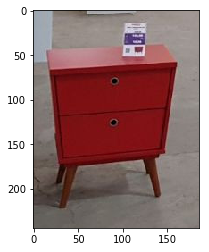

In [48]:
plt.imshow(Image.open(base_dir + '/nightstand.jpg'))

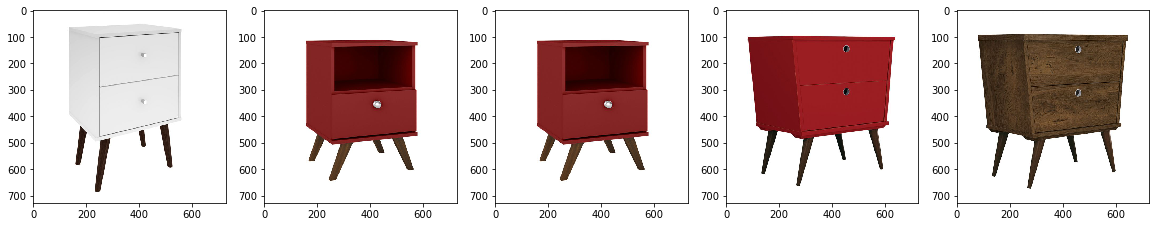

CPU times: user 2.6 s, sys: 4 ms, total: 2.6 s
Wall time: 3.37 s


In [49]:
%%time

# Runs a search, based on the test image
result = search_local_base(metadata, endpoint_name, base_dir + '/nightstand.jpg')
render_top_five(result)

### Random search

CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 72.2 ms


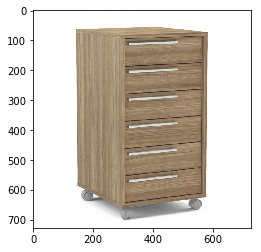

In [50]:
%%time
file_names = list(metadata)
random.shuffle(file_names)
file_name = base_dir + '/furniture/%s' % file_names[0]['image_path']
plt.imshow(Image.open(file_name))

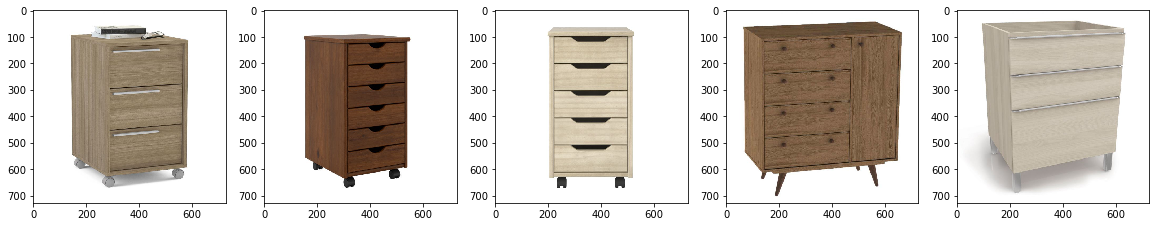

In [51]:
result = search_local_base(metadata, endpoint_name, file_name )
render_top_five(result)

## Cleaning

In [17]:
!rm -rf $base_dir

In [ ]:
%%time
sagemaker_session.delete_endpoint(endpoint_name)